# Team Momento Mori
    In this project, we plan to analyze CDC Data to predict the likelihood of an individual dying from a natural cause or an unnatural cause.

## 1) Installing Dependencies

In [471]:
# import the the essentials
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_confusion_matrix

## 2) Loading the Data set

In [459]:
years_data = set()
while True:
    year = input('Please the sequence of years (between 2005 and 2015), enter blank to end the sequence or enter all to get all data sets:')
    
    if year == 'all':
        years_data = set([i for i in range(2005,2016)])
        break
    if len(year) == 0: 
        print("You entered blank, sequence is ended. The data from the following years will be installed:")
        break
    try:
        year = int(year)
    except ValueError:
        print('Please enter valid integer value')
        continue
    if 2005 <= year <= 2015:
        years_data.add(str(year))
    else:
        print('Valid range is: 2005-2015')
    if len(years_data)>10:
        print('All data sets will be installed')
        break
    print(years_data)
print(years_data)


Please the sequence of years (between 2005 and 2015), enter blank to end the sequence or enter all to get all data sets: 2015


{'2015'}


Please the sequence of years (between 2005 and 2015), enter blank to end the sequence or enter all to get all data sets: 


You entered blank, sequence is ended. The data from the following years will be installed:
{'2015'}


In [469]:
try:
    del df
except:
    print('not defined')

not defined


In [461]:
df_dict = {} #installed df_dict

for year in years_data:
    df_dict[f'df_{year}']=pd.read_csv(f'archive/{year}_data.csv')

df = pd.concat(df_dict.values())

/var/folders/2n/x1v3x_n157b9sbshshb8yspc0000gn/T/ipykernel_11096/2932537648.py:4: DtypeWarning: Columns (40,41,42,43,61,62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dict[f'df_{year}']=pd.read_csv(f'archive/{year}_data.csv')


In [462]:
df.sample(5)

,resident_status,education_1989_revision,education_2003_revision,education_reporting_flag,month_of_death,sex,detail_age_type,detail_age,age_substitution_flag,age_recode_52,...,record_condition_18,record_condition_19,record_condition_20,race,bridged_race_flag,race_imputation_flag,race_recode_3,race_recode_5,hispanic_origin,hispanic_originrace_recode
299707,1,NaN,4.0,1,8,M,1,61,NaN,38,...,NaN,NaN,NaN,1,NaN,NaN,1,1,282,5
1430805,1,NaN,3.0,1,7,F,1,81,NaN,42,...,NaN,NaN,NaN,1,NaN,NaN,1,1,100,6
321636,1,NaN,3.0,1,9,M,1,91,NaN,44,...,NaN,NaN,NaN,1,NaN,NaN,1,1,100,6
417447,1,NaN,5.0,1,6,M,1,91,NaN,44,...,NaN,NaN,NaN,1,NaN,NaN,1,1,100,6
487422,1,NaN,3.0,1,1,M,1,87,NaN,43,...,NaN,NaN,NaN,1,NaN,NaN,1,1,100,6


In [463]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2718198 entries, 0 to 2718197
Data columns (total 77 columns):
 #   Column                                                  Dtype  
---  ------                                                  -----  
 0   resident_status                                         int64  
 1   education_1989_revision                                 float64
 2   education_2003_revision                                 float64
 3   education_reporting_flag                                int64  
 4   month_of_death                                          int64  
 5   sex                                                     object 
 6   detail_age_type                                         int64  
 7   detail_age                                              int64  
 8   age_substitution_flag                                   float64
 9   age_recode_52                                           int64  
 10  age_recode_27                                         

### Natural/Unnatural encoding
    For this project we look at '113_cause_recode' as target column.

We now encode the deaths which we rule unnatural.  By an **unnatural death**, we mean a death which is caused by one of the following causes:
1. Accident: 
    1. Unintentional injuries
    2. Transportation
    3. Motor vehicle, land/water/air/space
    4. Nontransport accidents
    5. Falls
    6. Accidental discharge of firearms
    7. Accidental drowning
    8. Accidental exposure to smoke, fire, flames
    9. Accidental poisoning
2. Homicide:
    1. Assault, not by the below causes
    2. Assault with firearms
    3. Assault with unspecified means
3. Suicide:
    1. Suicide by means other than the causes below
    2. Suicide by discharge of firearm
    3. Suidice by unspecified means
4. Execution
5. Undetermined intent
    1. U.I. except those listed below
    2. Discharge of firearms, undetermined intent
    3. Other
6. Operations of war
7. Complications from medical and surgical care

These correspond to cause of death codes 112-135 in the feature `113_cause_recode`.

There are no missing data in the target column:

In [280]:
df['358_cause_recode'].isna().sum()

0

In [281]:
# One hot encoding for classification '358_cause_recode'
df['unnatural']=1
df.loc[df['113_cause_recode']<=112,'unnatural']=0

In [282]:
df['unnatural'].value_counts(normalize=True)

0    0.919834
1    0.080166
Name: unnatural, dtype: float64

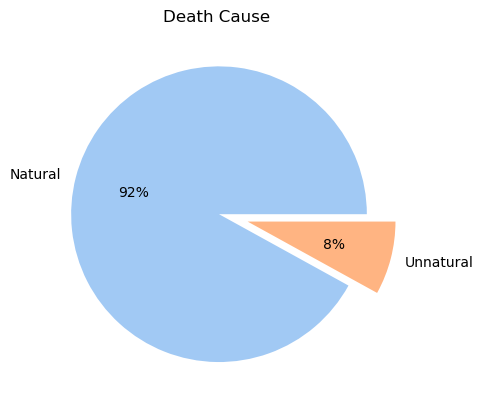

In [283]:
colors = sns.color_palette('pastel')[0:5]
labels = ["Natural", "Unnatural"]
explode = [ 0, .2]

#create pie chart
plt.title('Death Cause ')
plt.pie(df['unnatural'].value_counts(), labels = mylabels, colors = colors, explode = explode, autopct='%.0f%%')
plt.show()

As it can be seen above, about 92% of the deaths are natural, so we have classification problem with an inbalanced dataset.

Next we dive deeper into features and investigate features for our prediction model.

## 3)Exploratory Data Analysis

## 4) Data Cleaning

In [284]:
continuous_variables = ['education_2003_revision',
                     'detail_age']

categorical_variables = ['marital_status','sex']

features_of_interest = continuous_variables + categorical_variables

### 4.1) Inspection of missing data points

In [285]:
# Count Nan's: 
for column in df[features_of_interest]:
    print(f'\t {column} has :{ df[column].isna().sum() } many missing points and { len(df[column].unique()) } many different unique values \n')

	 education_2003_revision has :73043 many missing points and 10 many different unique values 

	 detail_age has :0 many missing points and 117 many different unique values 

	 marital_status has :0 many missing points and 5 many different unique values 

	 sex has :0 many missing points and 2 many different unique values 



In addition to missing values above, our research revealed that 'detail_age' = 999 and 'education_2003_revision'==9  translates to missing data.

Also NaN values for education_2003_revision are using the 1989 revision format of the item, which means we can potentialy recover missing points here by using data from education_1998_revision column.

In [286]:
print('\t Number missing datapoints in detail_age column:', (df['detail_age']==999).sum(), '\n\n',
    '\t Number of ACTUAL missing datapoints in education_2003_revision column: ', (df['education_2003_revision']==9).sum())

	 Number missing datapoints in detail_age column: 541 

 	 Number of ACTUAL missing datapoints in education_2003_revision column:  119831


### 4.2) Data Preprocessing
    

#### 4.2.1) One hot encode all categorical variables

In [287]:
from sklearn.preprocessing import FunctionTransformer

In [288]:
def one_hot_encoder(df):
    list_of_features = categorical_variables #Fill here
    df_copy = df.copy()
    
    for feature in list_of_features:
        temp = pd.get_dummies(df_copy[[feature]]) #There is a difference between df_copy[[feature]] and df_copy[feature], 
        returned_features = list(temp.columns)    #the former gives , e.g, 'marital_status_M' instead of M. This is to avoid overlapping names and get strings instead of value M
        df_copy[returned_features] = temp

    return df_copy.drop(columns = list_of_features)

one_hot_transformer = FunctionTransformer(one_hot_encoder)

#### 4.2.2) Replace missing values in Education 'education_2003_revision' column when it is possible to do so and create a unified 'education' column.

In [289]:
# MUCH MUCH MUCH FASTER SOLUTION

edu_dict = {99 : 9}
for education_1989_revision in range(18): 
    if education_1989_revision <= 8: education_2003_revision = 1
    elif education_1989_revision <= 11: education_2003_revision = 2
    elif education_1989_revision <= 12: education_2003_revision = 3
    elif education_1989_revision <= 13: education_2003_revision = 4
    elif education_1989_revision <= 15: education_2003_revision = 5
    elif education_1989_revision <= 16: education_2003_revision = 6
    elif education_1989_revision <= 17: education_2003_revision = 7
    
    edu_dict[education_1989_revision] = education_2003_revision
    
print('\t Education Convertion Dictionary: ', edu_dict)

#find NaN values in 'education_2003_revision' and fill them with appropriate 'education_1989_revision'
df['education'] = df['education_2003_revision'].fillna(df['education_1989_revision'].map(edu_dict))

	 Education Convertion Dictionary:  {99: 9, 0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 2, 10: 2, 11: 2, 12: 3, 13: 4, 14: 5, 15: 5, 16: 6, 17: 7}


#### 4.2.3) Drop missing value columns 

In [290]:
df.loc[df['detail_age']==999,'detail_age'] = np.nan #Identify the missing values
df.loc[df['education']==9,'education'] = np.nan

       
print('\t Number of dropped datapoints for detail_age column:', (df['detail_age'].isna()).sum(), '\n\n',
      '\t Number of dropped datapoints for education column: ', (df['education'].isna()).sum(),'\n\n')

df.dropna(subset = ['detail_age', 'education' ], inplace=True)

	 Number of dropped datapoints for detail_age column: 541 

 	 Number of dropped datapoints for education column:  120618 




### 4.3) Finalized Features and Data Frame

In [291]:
features_of_interest.remove('education_2003_revision')
features_of_interest.append('education')
features_of_interest

['detail_age', 'marital_status', 'sex', 'education']

In [292]:
temp_df = one_hot_transformer.transform(df[features_of_interest+['unnatural']])
del df
df = temp_df

df.sample(5)

,detail_age,education,unnatural,marital_status_D,marital_status_M,marital_status_S,marital_status_U,marital_status_W,sex_F,sex_M
0,84.0,3.0,0,0,1,0,0,0,0,1
1,70.0,6.0,0,0,1,0,0,0,0,1
2,91.0,3.0,0,0,0,0,0,1,1,0
3,40.0,3.0,1,0,0,1,0,0,1,0
4,89.0,5.0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...
2718185,1.0,1.0,0,0,0,1,0,0,0,1
2718186,84.0,7.0,0,0,0,0,0,1,0,1
2718188,65.0,6.0,0,0,1,0,0,0,0,1
2718189,5.0,1.0,0,0,0,1,0,0,0,1


In [293]:
features=list(df.columns)
features.remove('unnatural')
features

['detail_age',
 'education',
 'marital_status_D',
 'marital_status_M',
 'marital_status_S',
 'marital_status_U',
 'marital_status_W',
 'sex_F',
 'sex_M']

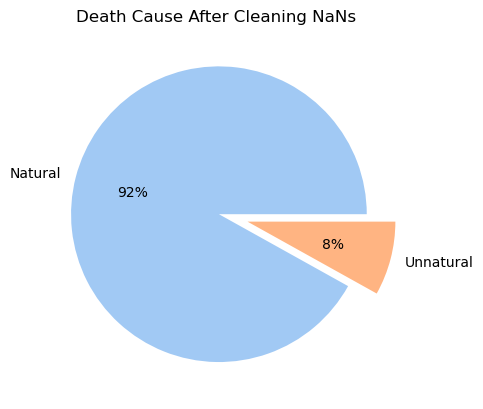

In [294]:
colors = sns.color_palette('pastel')[0:5]
labels = ["Natural", "Unnatural"]
explode = [ 0, .2]

#create pie chart
plt.title('Death Cause After Cleaning NaNs ')
plt.pie(df['unnatural'].value_counts(), labels = mylabels, colors = colors, explode = explode, autopct='%.0f%%')
plt.show()

## 5) Choice Of Metric

##  6) MODEL SELECTION

### 6.1) General Selection with Kfold

In [297]:
df_train, df_test = train_test_split(df.copy(),
                                     shuffle=True,
                                     random_state=123,
                                     test_size=.1,
                                     stratify=df['unnatural'].values)

In [409]:
baseline_models = {
    "Random_Guessing" : DummyClassifier(strategy="stratified") ,
    "Guess_Everything_Natural" : DummyClassifier(strategy="most_frequent"),
    "Logistic_Regression": LogisticRegression()
} 

In [410]:
models = {
    "Logistic_Regression_w_Scaling+Weights" : make_pipeline(StandardScaler(),LogisticRegression(class_weight = 'balanced')),
    "Logistic_Regression_w_Weights" : LogisticRegression(class_weight = 'balanced'),
    "Random_Forest_Classifier" : RandomForestClassifier(n_estimators=100,max_depth=8),
    "Random_Forest_Classifier_w_Weights" : RandomForestClassifier(n_estimators=100,max_depth=8,class_weight = 'balanced'),
    "Gaussian_Bayes" : GaussianNB(),
    "XGboost" : xgboost.XGBClassifier(n_estimators = 10,
                                      max_depth = 8, 
                                      scale_pos_weight = 700,
                                      random_state = 123)
}

In [411]:
models.update(baseline_models)

Logistic_Regression_w_Scaling+Weights 
 Split: 0
Logistic_Regression_w_Scaling+Weights 0th validation 
               precision    recall  f1-score   support

           0       0.97      0.78      0.86    429740
           1       0.22      0.71      0.34     37794

    accuracy                           0.78    467534
   macro avg       0.60      0.75      0.60    467534
weighted avg       0.91      0.78      0.82    467534
 

Prediction Percentages : 
 0    0.741249
1    0.258751
dtype: float64
------------------------------------------------------------
Logistic_Regression_w_Weights 
 Split: 0
Logistic_Regression_w_Weights 0th validation 
               precision    recall  f1-score   support

           0       0.97      0.78      0.86    429740
           1       0.22      0.71      0.34     37794

    accuracy                           0.78    467534
   macro avg       0.60      0.75      0.60    467534
weighted avg       0.91      0.78      0.82    467534
 

Prediction Percenta

/opt/homebrew/Caskroom/miniforge/base/envs/ryol_general/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ryol_general/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ryol_general/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

Guess_Everything_Natural 0th validation 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96    429740
           1       0.00      0.00      0.00     37794

    accuracy                           0.92    467534
   macro avg       0.46      0.50      0.48    467534
weighted avg       0.84      0.92      0.88    467534
 

Prediction Percentages : 
 0    1.0
dtype: float64
------------------------------------------------------------
Logistic_Regression 
 Split: 0


/opt/homebrew/Caskroom/miniforge/base/envs/ryol_general/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic_Regression 0th validation 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96    429740
           1       0.51      0.14      0.22     37794

    accuracy                           0.92    467534
   macro avg       0.72      0.56      0.59    467534
weighted avg       0.90      0.92      0.90    467534
 

Prediction Percentages : 
 0    0.97797
1    0.02203
dtype: float64
------------------------------------------------------------


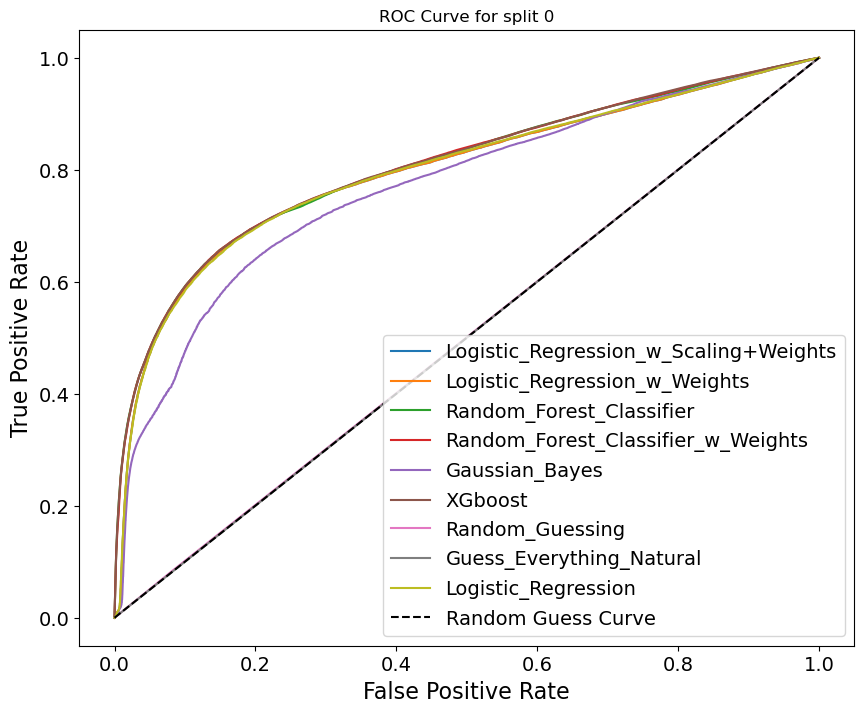

Logistic_Regression_w_Scaling+Weights 
 Split: 1
Logistic_Regression_w_Scaling+Weights 1th validation 
               precision    recall  f1-score   support

           0       0.97      0.78      0.87    429739
           1       0.22      0.71      0.34     37795

    accuracy                           0.78    467534
   macro avg       0.60      0.75      0.60    467534
weighted avg       0.91      0.78      0.82    467534
 

Prediction Percentages : 
 0    0.741617
1    0.258383
dtype: float64
------------------------------------------------------------
Logistic_Regression_w_Weights 
 Split: 1


/opt/homebrew/Caskroom/miniforge/base/envs/ryol_general/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic_Regression_w_Weights 1th validation 
               precision    recall  f1-score   support

           0       0.97      0.78      0.87    429739
           1       0.22      0.71      0.34     37795

    accuracy                           0.78    467534
   macro avg       0.60      0.75      0.60    467534
weighted avg       0.91      0.78      0.82    467534
 

Prediction Percentages : 
 0    0.742663
1    0.257337
dtype: float64
------------------------------------------------------------
Random_Forest_Classifier 
 Split: 1
Random_Forest_Classifier 1th validation 
               precision    recall  f1-score   support

           0       0.94      0.99      0.96    429739
           1       0.70      0.28      0.40     37795

    accuracy                           0.93    467534
   macro avg       0.82      0.64      0.68    467534
weighted avg       0.92      0.93      0.92    467534
 

Prediction Percentages : 
 0    0.967348
1    0.032652
dtype: float64
----------------

/opt/homebrew/Caskroom/miniforge/base/envs/ryol_general/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ryol_general/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ryol_general/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

Guess_Everything_Natural 1th validation 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96    429739
           1       0.00      0.00      0.00     37795

    accuracy                           0.92    467534
   macro avg       0.46      0.50      0.48    467534
weighted avg       0.84      0.92      0.88    467534
 

Prediction Percentages : 
 0    1.0
dtype: float64
------------------------------------------------------------
Logistic_Regression 
 Split: 1
Logistic_Regression 1th validation 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96    429739
           1       0.51      0.14      0.22     37795

    accuracy                           0.92    467534
   macro avg       0.72      0.56      0.59    467534
weighted avg       0.90      0.92      0.90    467534
 

Prediction Percentages : 
 0    0.978053
1    0.021947
dtype: float64
--------------------------------------------------

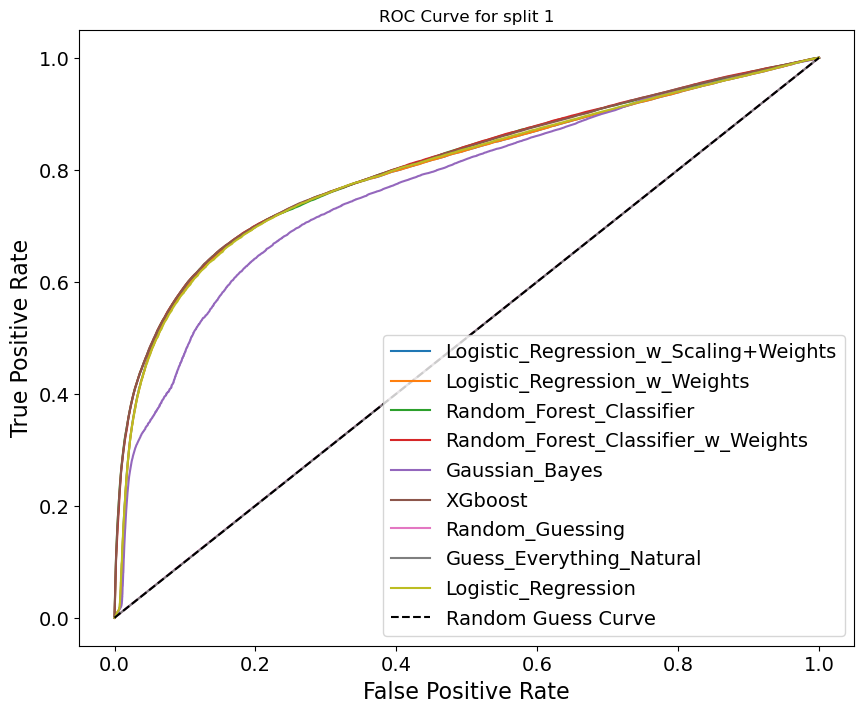

Logistic_Regression_w_Scaling+Weights 
 Split: 2
Logistic_Regression_w_Scaling+Weights 2th validation 
               precision    recall  f1-score   support

           0       0.97      0.78      0.86    429739
           1       0.22      0.70      0.34     37795

    accuracy                           0.77    467534
   macro avg       0.59      0.74      0.60    467534
weighted avg       0.91      0.77      0.82    467534
 

Prediction Percentages : 
 0    0.74074
1    0.25926
dtype: float64
------------------------------------------------------------
Logistic_Regression_w_Weights 
 Split: 2


/opt/homebrew/Caskroom/miniforge/base/envs/ryol_general/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic_Regression_w_Weights 2th validation 
               precision    recall  f1-score   support

           0       0.97      0.78      0.86    429739
           1       0.22      0.71      0.33     37795

    accuracy                           0.77    467534
   macro avg       0.59      0.74      0.60    467534
weighted avg       0.91      0.77      0.82    467534
 

Prediction Percentages : 
 0    0.740149
1    0.259851
dtype: float64
------------------------------------------------------------
Random_Forest_Classifier 
 Split: 2
Random_Forest_Classifier 2th validation 
               precision    recall  f1-score   support

           0       0.94      0.99      0.96    429739
           1       0.69      0.28      0.40     37795

    accuracy                           0.93    467534
   macro avg       0.81      0.63      0.68    467534
weighted avg       0.92      0.93      0.92    467534
 

Prediction Percentages : 
 0    0.96708
1    0.03292
dtype: float64
------------------

/opt/homebrew/Caskroom/miniforge/base/envs/ryol_general/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ryol_general/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ryol_general/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

Guess_Everything_Natural 2th validation 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96    429739
           1       0.00      0.00      0.00     37795

    accuracy                           0.92    467534
   macro avg       0.46      0.50      0.48    467534
weighted avg       0.84      0.92      0.88    467534
 

Prediction Percentages : 
 0    1.0
dtype: float64
------------------------------------------------------------
Logistic_Regression 
 Split: 2


/opt/homebrew/Caskroom/miniforge/base/envs/ryol_general/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic_Regression 2th validation 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96    429739
           1       0.52      0.14      0.22     37795

    accuracy                           0.92    467534
   macro avg       0.72      0.57      0.59    467534
weighted avg       0.90      0.92      0.90    467534
 

Prediction Percentages : 
 0    0.977717
1    0.022283
dtype: float64
------------------------------------------------------------


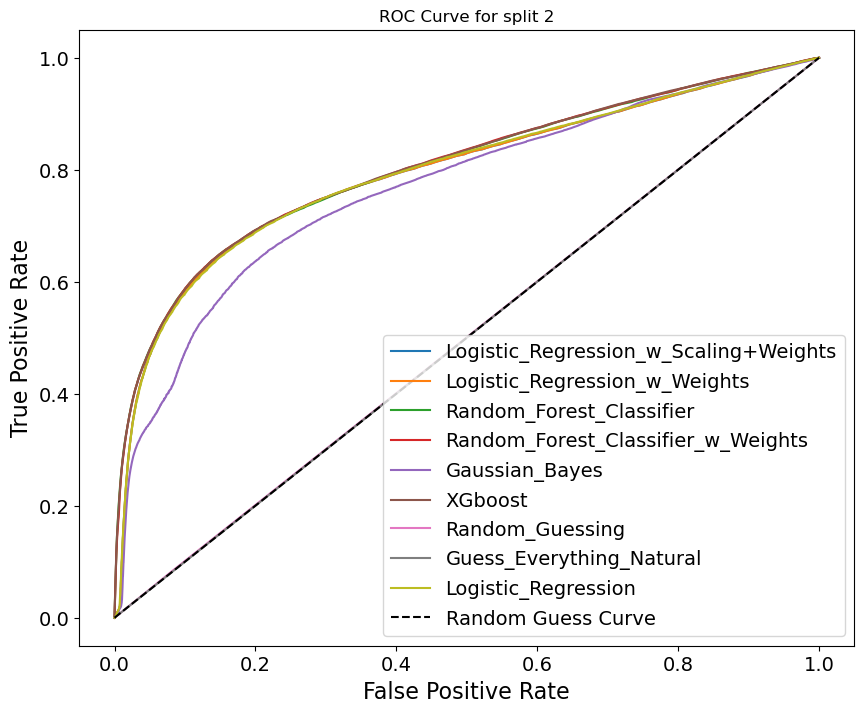

Logistic_Regression_w_Scaling+Weights 
 Split: 3
Logistic_Regression_w_Scaling+Weights 3th validation 
               precision    recall  f1-score   support

           0       0.97      0.78      0.87    429739
           1       0.22      0.71      0.34     37795

    accuracy                           0.78    467534
   macro avg       0.60      0.75      0.60    467534
weighted avg       0.91      0.78      0.82    467534
 

Prediction Percentages : 
 0    0.741739
1    0.258261
dtype: float64
------------------------------------------------------------
Logistic_Regression_w_Weights 
 Split: 3


/opt/homebrew/Caskroom/miniforge/base/envs/ryol_general/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic_Regression_w_Weights 3th validation 
               precision    recall  f1-score   support

           0       0.97      0.78      0.86    429739
           1       0.22      0.71      0.34     37795

    accuracy                           0.78    467534
   macro avg       0.60      0.75      0.60    467534
weighted avg       0.91      0.78      0.82    467534
 

Prediction Percentages : 
 0    0.741531
1    0.258469
dtype: float64
------------------------------------------------------------
Random_Forest_Classifier 
 Split: 3
Random_Forest_Classifier 3th validation 
               precision    recall  f1-score   support

           0       0.94      0.99      0.96    429739
           1       0.70      0.28      0.40     37795

    accuracy                           0.93    467534
   macro avg       0.82      0.63      0.68    467534
weighted avg       0.92      0.93      0.92    467534
 

Prediction Percentages : 
 0    0.96825
1    0.03175
dtype: float64
------------------

/opt/homebrew/Caskroom/miniforge/base/envs/ryol_general/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ryol_general/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ryol_general/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

Guess_Everything_Natural 3th validation 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96    429739
           1       0.00      0.00      0.00     37795

    accuracy                           0.92    467534
   macro avg       0.46      0.50      0.48    467534
weighted avg       0.84      0.92      0.88    467534
 

Prediction Percentages : 
 0    1.0
dtype: float64
------------------------------------------------------------
Logistic_Regression 
 Split: 3


/opt/homebrew/Caskroom/miniforge/base/envs/ryol_general/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic_Regression 3th validation 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96    429739
           1       0.51      0.14      0.22     37795

    accuracy                           0.92    467534
   macro avg       0.72      0.56      0.59    467534
weighted avg       0.89      0.92      0.90    467534
 

Prediction Percentages : 
 0    0.97829
1    0.02171
dtype: float64
------------------------------------------------------------


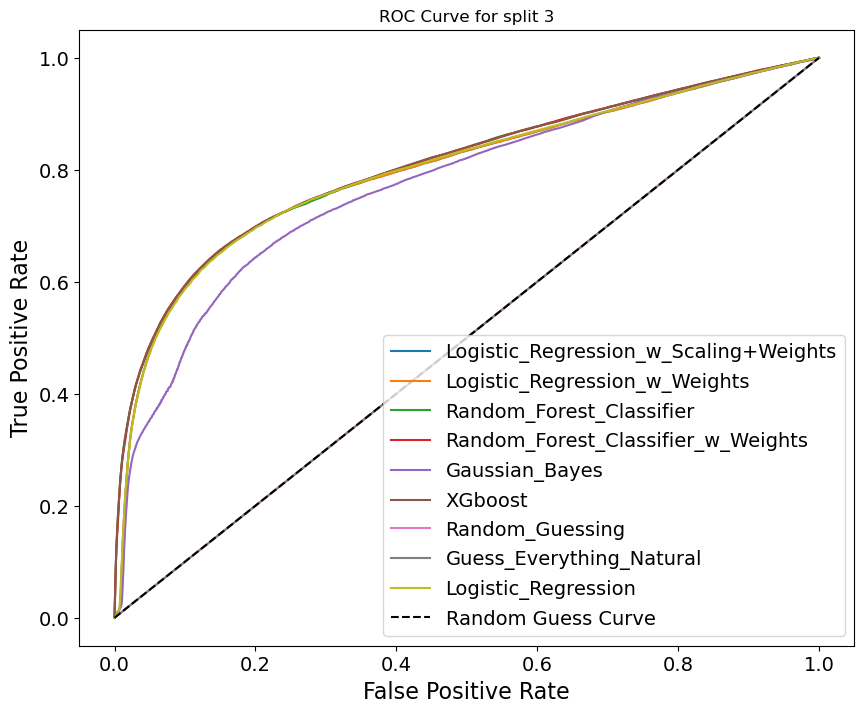

Logistic_Regression_w_Scaling+Weights 
 Split: 4
Logistic_Regression_w_Scaling+Weights 4th validation 
               precision    recall  f1-score   support

           0       0.97      0.78      0.86    429739
           1       0.22      0.71      0.34     37794

    accuracy                           0.78    467533
   macro avg       0.60      0.75      0.60    467533
weighted avg       0.91      0.78      0.82    467533
 

Prediction Percentages : 
 0    0.74112
1    0.25888
dtype: float64
------------------------------------------------------------
Logistic_Regression_w_Weights 
 Split: 4


/opt/homebrew/Caskroom/miniforge/base/envs/ryol_general/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic_Regression_w_Weights 4th validation 
               precision    recall  f1-score   support

           0       0.97      0.78      0.86    429739
           1       0.22      0.71      0.34     37794

    accuracy                           0.78    467533
   macro avg       0.60      0.75      0.60    467533
weighted avg       0.91      0.78      0.82    467533
 

Prediction Percentages : 
 0    0.74112
1    0.25888
dtype: float64
------------------------------------------------------------
Random_Forest_Classifier 
 Split: 4
Random_Forest_Classifier 4th validation 
               precision    recall  f1-score   support

           0       0.94      0.99      0.96    429739
           1       0.69      0.28      0.40     37794

    accuracy                           0.93    467533
   macro avg       0.82      0.63      0.68    467533
weighted avg       0.92      0.93      0.92    467533
 

Prediction Percentages : 
 0    0.967468
1    0.032532
dtype: float64
------------------

/opt/homebrew/Caskroom/miniforge/base/envs/ryol_general/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ryol_general/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ryol_general/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

Guess_Everything_Natural 4th validation 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96    429739
           1       0.00      0.00      0.00     37794

    accuracy                           0.92    467533
   macro avg       0.46      0.50      0.48    467533
weighted avg       0.84      0.92      0.88    467533
 

Prediction Percentages : 
 0    1.0
dtype: float64
------------------------------------------------------------
Logistic_Regression 
 Split: 4


/opt/homebrew/Caskroom/miniforge/base/envs/ryol_general/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic_Regression 4th validation 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96    429739
           1       0.51      0.14      0.22     37794

    accuracy                           0.92    467533
   macro avg       0.72      0.57      0.59    467533
weighted avg       0.90      0.92      0.90    467533
 

Prediction Percentages : 
 0    0.977537
1    0.022463
dtype: float64
------------------------------------------------------------


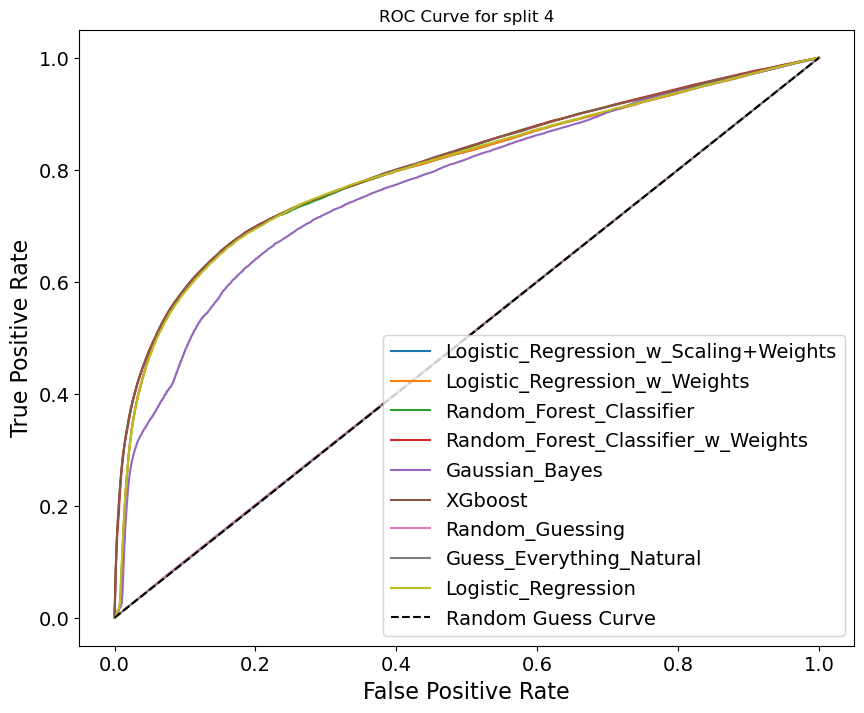

In [412]:
## Make a KFold object
n_splits = 5
kfold = StratifiedKFold(n_splits= n_splits, 
                random_state=123,
                shuffle=True)

## This arrays will hold the f1-macro and recall score for each model and split
f1s = np.zeros((len(models), n_splits))
rcls=np.zeros((len(models), n_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(df_train,df_train.unnatural):
    
    ## cv training and holdout set
    df_tt,  df_ho = df_train.iloc[train_index], df_train.iloc[test_index]
    
    ## ROC curve dictionary to display 
    ROC_dict = {}
    
    ##train the models in the split
    for model_index, (model_name, model) in enumerate(models.items()):
        print(model_name, '\n', f'Split: {i}')
        model.fit(df_tt[features], df_tt['unnatural'].values)
        pred = model.predict(df_ho[features])
        pred_proba = model.predict_proba(df_ho[features])[:,1]
        
        f1s[model_index,i] = f1_score(df_ho['unnatural'].values, pred, average = 'macro')
        rcls[model_index, i] = recall_score(df_ho['unnatural'].values, pred)
        
        print(f'{model_name} {i}th validation \n', classification_report(df_ho['unnatural'].values, pred),'\n')
        print('Prediction Percentages : \n', pd.Series(pred).value_counts(normalize=True))
        print('--'*30)
        ROC_dict[model_name] = {}
        ROC_dict[model_name]['fprs'], ROC_dict[model_name]['tprs'], ROC_dict[model_name]['cutoffs'] = roc_curve(df_ho['unnatural'].values,pred_proba)
    
    ##Display the ROC curve
    plt.figure(figsize=(10,8))
    plt.title(f'ROC Curve for split {i}')
    for model_name in ROC_dict.keys():
        plt.plot(ROC_dict[model_name]['fprs'], ROC_dict[model_name]['tprs'], label = f'{model_name}')
    
    plt.plot([0,1],[0,1],'k--', label ='Random Guess Curve')
    plt.xlabel('False Positive Rate', fontsize =16)
    plt.ylabel('True Positive Rate', fontsize =16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)

    plt.show()

    i = i + 1

In [413]:
recalls = pd.DataFrame(rcls,
            index = list(models.keys()),
            columns = [f'recall_{i}' for i in range(n_splits)])
recalls['recall_mean'] = recalls.mean(axis=1)
f1_scores = pd.DataFrame(f1s,
            index = list(models.keys()),
            columns = [f'f1_macro_{i}' for i in range(n_splits)])
f1_scores['f1_mean'] = f1_scores.mean(axis=1)
display(pd.concat([recalls, f1_scores], axis=1))




,recall_0,recall_1,recall_2,recall_3,recall_4,recall_mean,f1_macro_0,f1_macro_1,f1_macro_2,f1_macro_3,f1_macro_4,f1_mean
Logistic_Regression_w_Scaling+Weights,0.710695,0.711761,0.704882,0.711364,0.710933,0.709927,0.601516,0.602135,0.599428,0.602124,0.601477,0.601336
Logistic_Regression_w_Weights,0.710695,0.710517,0.705226,0.711523,0.710933,0.709779,0.601516,0.602659,0.599034,0.601995,0.601477,0.601336
Random_Forest_Classifier,0.277875,0.281016,0.280011,0.276624,0.278748,0.278855,0.680504,0.682128,0.680827,0.680639,0.680657,0.680951
Random_Forest_Classifier_w_Weights,0.657168,0.655563,0.652520,0.657627,0.650897,0.654755,0.647648,0.648576,0.643609,0.646432,0.647465,0.646746
Gaussian_Bayes,0.425015,0.424897,0.422146,0.427226,0.427502,0.425357,0.643237,0.643287,0.642669,0.645014,0.644167,0.643675
XGboost,0.999894,0.999921,0.999815,0.999815,0.999868,0.999862,0.075157,0.075141,0.075230,0.075374,0.075210,0.075223
Random_Guessing,0.079642,0.078635,0.080090,0.081810,0.080171,0.080070,0.499600,0.498945,0.499748,0.500231,0.499820,0.499669
Guess_Everything_Natural,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.478940,0.478939,0.478939,0.478939,0.478939,0.478939
Logistic_Regression,0.140102,0.139225,0.142770,0.136394,0.142377,0.140173,0.588955,0.588341,0.590822,0.586307,0.590254,0.588936


### 6.2) Hyperparameter Tuning for Best Candidates

In [54]:
param_grid = { 'n_estimators': [10,20,50,100,150],
          #    'max_features': [ 'sqrt', 'log2'],
              'max_depth' : [2,4,5,6,7,8],
              'criterion' :['gini', 'entropy']
             }

In [55]:
grid_cv=GridSearchCV(RandomForestClassifier(class_weight = 'balanced',random_state = 123),#put model here something like LinearRegression()
                     param_grid = param_grid,
                     scoring = 'recall',
                     cv = StratifiedKFold(n_splits=5, random_state=101, shuffle=True),
                     verbose=4)


grid_cv.fit(df_train[features],df_train.unnatural)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END criterion=gini, max_depth=2, n_estimators=10;, score=0.659 total time=   2.5s
[CV 2/5] END criterion=gini, max_depth=2, n_estimators=10;, score=0.656 total time=   2.4s
[CV 3/5] END criterion=gini, max_depth=2, n_estimators=10;, score=0.664 total time=   2.3s
[CV 4/5] END criterion=gini, max_depth=2, n_estimators=10;, score=0.659 total time=   2.3s
[CV 5/5] END criterion=gini, max_depth=2, n_estimators=10;, score=0.657 total time=   2.4s
[CV 1/5] END criterion=gini, max_depth=2, n_estimators=20;, score=0.654 total time=   4.2s
[CV 2/5] END criterion=gini, max_depth=2, n_estimators=20;, score=0.653 total time=   4.4s
[CV 3/5] END criterion=gini, max_depth=2, n_estimators=20;, score=0.654 total time=   4.4s
[CV 4/5] END criterion=gini, max_depth=2, n_estimators=20;, score=0.651 total time=   4.3s
[CV 5/5] END criterion=gini, max_depth=2, n_estimators=20;, score=0.649 total time=   4.4s
[CV 1/5] END criterion=gini,

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=101, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=123),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 5, 6, 7, 8],
                         'n_estimators': [10, 20, 50, 100, 150]},
             scoring='recall', verbose=4)

In [420]:
model = LogisticRegression(max_iter = 10000, class_weight = 'balanced')
solvers = [#'newton-cg',
           'lbfgs'
           #'liblinear'
            ]
penalty = ['l2' 
           #'elasticnet',
           #'none'
          ]
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,
            penalty=penalty,
            C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10,
                             n_repeats=1, 
                             random_state=123)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid,
                           cv=cv, scoring='recall',
                           error_score=0,
                           verbose=4)
grid_result = grid_search.fit(df_train[features], df_train.unnatural )

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10] END ..C=100, penalty=l2, solver=lbfgs;, score=0.709 total time=   8.3s
[CV 2/10] END ..C=100, penalty=l2, solver=lbfgs;, score=0.713 total time=   7.1s
[CV 3/10] END ..C=100, penalty=l2, solver=lbfgs;, score=0.714 total time=   6.6s
[CV 4/10] END ..C=100, penalty=l2, solver=lbfgs;, score=0.709 total time=   8.6s
[CV 5/10] END ..C=100, penalty=l2, solver=lbfgs;, score=0.706 total time=   8.2s
[CV 6/10] END ..C=100, penalty=l2, solver=lbfgs;, score=0.704 total time=   7.7s
[CV 7/10] END ..C=100, penalty=l2, solver=lbfgs;, score=0.712 total time=   6.9s
[CV 8/10] END ..C=100, penalty=l2, solver=lbfgs;, score=0.711 total time=   9.1s
[CV 9/10] END ..C=100, penalty=l2, solver=lbfgs;, score=0.713 total time=   8.3s
[CV 10/10] END .C=100, penalty=l2, solver=lbfgs;, score=0.709 total time=   9.7s
[CV 1/10] END ...C=10, penalty=l2, solver=lbfgs;, score=0.709 total time=   5.7s
[CV 2/10] END ...C=10, penalty=l2, solver=lbfgs;

## 7) Deploying the Final Model

/opt/homebrew/Caskroom/miniforge/base/envs/ryol_general/lib/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


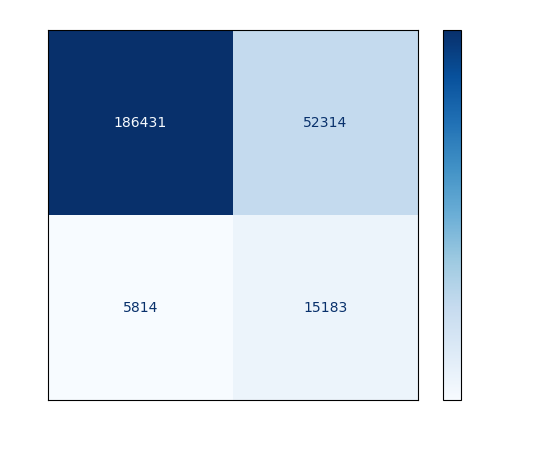

In [478]:
color = 'white'
matrix = plot_confusion_matrix(grid_search.best_estimator_, df_test[features], df_test.unnatural.values, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

In [486]:
final_predictions = grid_search.best_estimator_.predict(df_test[features])

print(classification_report(df_test.unnatural.values, final_predictions))
print('f1 macro test score :', f1_score(df_test.unnatural.values, final_predictions, average = 'macro'))
print('recall test score :', recall_score(df_test.unnatural.values, final_predictions))

print('Prediction Percentages : \n', pd.Series(final_predictions).value_counts(normalize=True))

              precision    recall  f1-score   support

           0       0.97      0.78      0.87    238745
           1       0.22      0.72      0.34     20997

    accuracy                           0.78    259742
   macro avg       0.60      0.75      0.60    259742
weighted avg       0.91      0.78      0.82    259742

f1 macro test score : 0.6041355146256409
recall test score : 0.723103300471496
Prediction Percentages : 
 0    0.740138
1    0.259862
dtype: float64
